# Solve an optimization problem using a parametric NLIW model

## Necessary data

 - Tidal amplitude at a point
 - Stratification parameters $\alpha$ and $c$.
 - Time series of NLIW amplitude, $A$
 
## Models

The optimization problem has the form

$$
A(t) = \hat{A}(t) a_0(t-\hat{T}(t))
$$

where $\hat{A}(t)$ is an amplitude distortion function, $a_0(t)$ is the initial internal tide amplitude, $\hat{T}(t)$ is a time lag function. The amplitude and time lag functions are determined empirically from ~O(10$^5$) KdV model solutions and are found to be functions of $\hat{L}$, the nondimensional steepening length scale, $L_s/L$, where 
$$
L_s = \frac{c^2}{\alpha \omega a_0}
$$
and $L$ is the distance from the generation site or the 'equivalent deep-water' site. This is the important link that we have identified. The amplitude function is

$$
\hat{A}(t) = \frac{A_{max}}{a_0} = f(\hat{L}) = -A_{h} + 0.5(A_h - A_l)\left(
    1+ \tanh\left( \frac{\hat{L} - L_A}{0.5\delta_{lA}}\right) \right)
$$

$$
\hat{A}(t) = \frac{A_{max}}{a_0} = f(\hat{L}) = 
$$
where $A_h$, $A_l$, $L_A$, $\delta_{lA}$ are all emirically determined parameters.  Similarly, the time lag function is

$$
\hat{T}(t) = \frac{T_{max} c}{L} =  f(\hat{L}) = -T_{h} + 0.5(T_h - T_l)\left(
    1+ \tanh\left( \frac{\hat{L} - L_T}{0.5\delta_{lT}}\right) \right)
$$
that also has four unknown parameters $T_h$, $T_l$, $L_T$, $\delta_{lT}$. The dimensional maximum amplitude, $A_{max}$, and time of maximum amplitude, $T_{max}$, are extracted from the KdV solutions and the parametric variables are found via...(least-squares, Bayesian inference...). 

The initial internal tide amplitude is unknown and we assume a linear relationship to the tidal elevation envelope, specifically

$$
a_0(t) = \beta_0 + \beta_1 \hat{\zeta}(t - \hat{T}(t))+\epsilon
$$
where $\hat{\zeta}$ is the analytical amplitude envelope of the tidal elevation signal, $\zeta(t)$, which is obtained from the OSU Indonesian Seas tidal model i.e. TPXO (REF).
The problem is to determine the parameters $\beta_0$ and $\beta_1$ and characterize the error, $\epsilon$. The error term is a crude way of incorporating unknown processes that alter the initial wave amplitude e.g., remote internal waves, mesoscale amplitude modulation, and generation modulation.




In [4]:
# Load the libraries
import h5py
import numpy as np
import pandas as pd
import xarray as xr
from datetime import datetime
import matplotlib.pyplot as plt

from scipy import signal
from scipy.optimize import minimize

from soda.utils.timeseries import timeseries, skill, rmse
from soda.utils.uspectra import uspectra, getTideFreq
from soda.utils.othertime import SecondsSince, TimeVector
from soda.dataio.conversion import readotps
from soda.utils.myairsea import pol2cart

from glob import glob

In [5]:
%matplotlib notebook

# Load the tidal amplitude data

In [6]:
# Load the tidal amplitude
##########
# Inputs
xpt, ypt = 123.346383, -13.75895

# Grab the barotropic tide data
tidemod = '/home/suntans/Share/ScottReef/DATA/TIDES/Ind2016/Model_Ind_2016'
tidecons = ['M2','S2','N2','K2','K1','O1','P1','Q1']

time = TimeVector('20160501.000000','20170501.000000',3600)

basetime = datetime(2016,1,1)
##########
# Extract the tidal height for the whole period
eta, U,V = readotps.tide_pred(tidemod,np.array([xpt]),
                        np.array([ypt]),time)

# Manually compute the amp and phase that includes the nodal corrections
eta_ts = timeseries(time,eta)

eta_amp, eta_phs, omega,_,eta_harmonic,_=eta_ts.tidefit(frqnames=tidecons,basetime=basetime)

h_re, h_im = pol2cart(eta_phs.data, eta_amp.data)
nf = len(omega)
beta_s = np.zeros((2*nf,))
beta_s[0:-1:2] = h_re.ravel()
beta_s[1::2] = h_im.ravel()

beta_s

Interpolating consituent: M2...


/home/suntans/code/soda/soda/dataio/conversion/readotps.py:325: RuntimeWarning: divide by zero encountered in true_divide
  tmp_u_re /= depth
/home/suntans/code/soda/soda/dataio/conversion/readotps.py:325: RuntimeWarning: invalid value encountered in true_divide
  tmp_u_re /= depth
/home/suntans/code/soda/soda/dataio/conversion/readotps.py:326: RuntimeWarning: divide by zero encountered in true_divide
  tmp_u_im /= depth
/home/suntans/code/soda/soda/dataio/conversion/readotps.py:326: RuntimeWarning: invalid value encountered in true_divide
  tmp_u_im /= depth
/home/suntans/code/soda/soda/dataio/conversion/readotps.py:327: RuntimeWarning: divide by zero encountered in true_divide
  tmp_v_re /= depth
/home/suntans/code/soda/soda/dataio/conversion/readotps.py:327: RuntimeWarning: invalid value encountered in true_divide
  tmp_v_re /= depth
/home/suntans/code/soda/soda/dataio/conversion/readotps.py:328: RuntimeWarning: divide by zero encountered in true_divide
  tmp_v_im /= depth
/home/sun

Interpolating consituent: S2...
Interpolating consituent: N2...
Interpolating consituent: K2...
Interpolating consituent: K1...
Interpolating consituent: O1...
Interpolating consituent: P1...
Interpolating consituent: Q1...


/home/suntans/code/soda/soda/utils/harmonic_analysis.py:139: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  b = np.linalg.lstsq(A,y)


array([-1.06509122, -0.73217239, -0.37533113,  0.61863875,  0.21996617,
       -0.03981784,  0.03631467, -0.15276493, -0.23136769,  0.0536182 ,
        0.10304469, -0.08413635, -0.07918459, -0.00313358, -0.01240162,
        0.02753476])

# Load the observed amplitude data

In [7]:
###########
ncfile = '/home/suntans/Share/ARCHub/DATA/FIELD/ShellCrux/KP150_Fitted_Buoyancy_wout_motion.nc'
mode = 0
###########

ds1 = xr.open_dataset(ncfile,group='KP150_phs1')
ds2 = xr.open_dataset(ncfile,group='KP150_phs2')

# Merge the two

A_n = xr.concat([ds1['A_n'][:,mode],ds2['A_n'][:,mode]], dim='time')
#a0 = xr.concat([ds1['amp'][:,mode,0],ds2['amp'][:,mode,0]], dim='timeslow')

# Quality control
A_n.loc['2016-09-18':'2016-10-31']=np.nan


# Create a time series of single days with the max amplitude 
time1 = pd.date_range('2016-5-1','2016-9-15') 
time2 = pd.date_range('2016-11-1','2017-5-1')
time = time1.append(time2)

#time = pd.date_range('2017-1-1','2017-4-20') 



<IPython.core.display.Javascript object>


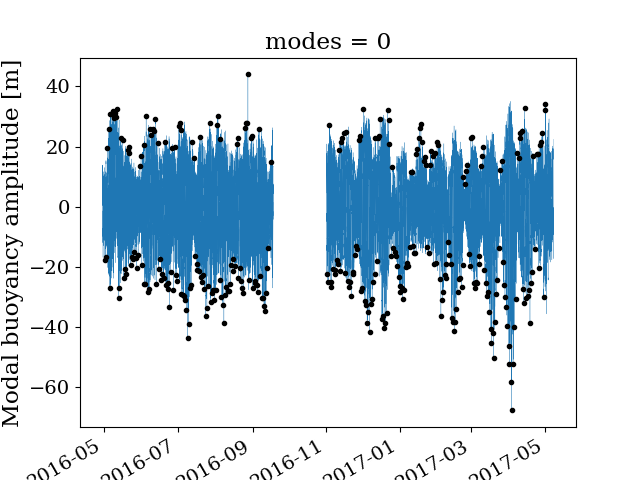

In [8]:
# Find the A_max over one day blocks
def maximum_amplitude_finder(amp_signal):
    amp_min = np.min(amp_signal)
    amp_max = np.max(amp_signal)
    if np.abs(amp_min)>amp_max:
        return amp_min, np.argwhere(amp_signal==amp_min)[0][0]
    else:
        return amp_max, np.argwhere(amp_signal==amp_max)[0][0]

Amax_all = []
Amax_time = []
for t1 in time:
    t2 = t1 + np.timedelta64(1,'D')
    
    Amax, tidx = maximum_amplitude_finder(A_n.sel(time=slice(t1,t2)).values)
    tmax = A_n.sel(time=slice(t1,t2)).time[tidx].values
    Amax_all.append(Amax)
    Amax_time.append(tmax)

#ds_A = pd.Series(Amax_all, index=Amax_time)
ds_A = xr.DataArray(Amax_all, coords={'time':Amax_time}, dims=('time',))

plt.figure()
A_n.plot(lw=0.2)
plt.plot(ds_A['time'], ds_A.values,'k.')

# Load the stratification data

In [25]:
#ds_S = xr.open_dataset('../inputs/Crux_KP150_12mth_Density_lowpass_nliw.nc')
#ds_S['time'] += np.timedelta64(1,'D')

datadir = '../../run_ddcurves/DATA_SHELL/'
ds_S = xr.open_dataset('%s/ShellCrux_Uniltered_Density_BHM_VI_20162017_nliw.nc'%datadir,)
# Offset the time by one day
ds_S['time'] += np.timedelta64(1,'D')

#datadir = '../../run_ddcurves/DATA_SHELL/'
#ds_S = xr.open_dataset('%s/ShellCrux_Filtered_Density_BHM_MCMC_20162017_nliw.nc'%datadir,)
# Offset the time by one day
#ds_S['time'] += np.timedelta64(1,'D')

ds_S


<xarray.Dataset>
Dimensions:   (ensemble: 2000, params: 6, time: 374)
Coordinates:
  * time      (time) datetime64[ns] 2016-04-30T23:15:00 ... 2017-05-08T06:40:00
  * ensemble  (ensemble) int64 0 1 2 3 4 5 6 ... 1994 1995 1996 1997 1998 1999
  * params    (params) int64 0 1 2 3 4 5
Data variables:
    cn        (time, ensemble) float64 ...
    alpha     (time, ensemble) float64 ...
    beta      (params, time, ensemble) float64 ...

In [26]:
# Load the stratification parameters from runs
ds_raw = xr.open_dataset('../output/2019-07-15--11-53-58_magnus_kdv_runs.nc') #KdV w/ new a0
#ds = xr.open_dataset('../output/2019-07-16--05-17-35_magnus_kdv_runs.nc') #eKdV w/ new a0
betafile = '../inputs/ShellCrux_Filtered_Density_BHM_VI_20162017.h5'


# Get the time from the beta file
with h5py.File(betafile,'r') as f:
    t=f['data/time'][:].astype('<M8[ns]')
time = t
nt = time.shape[0]


ds = ds_raw.sel(time=range(nt))
ds

# Convert it
coords={'time':time, 'ensemble':range(500)}
dims = ('time','ensemble')
ds_S = xr.Dataset({
    'cn':xr.DataArray(ds.cn_mu.values.T,coords=coords,dims=dims),
    'alpha':xr.DataArray(ds.alpha_mu.values.T,coords=coords,dims=dims),

}
)
ds_S

<xarray.Dataset>
Dimensions:   (ensemble: 500, time: 369)
Coordinates:
  * time      (time) datetime64[ns] 2016-05-03T05:15:00 ... 2017-05-07T18:40:00
  * ensemble  (ensemble) int64 0 1 2 3 4 5 6 7 ... 493 494 495 496 497 498 499
Data variables:
    cn        (time, ensemble) float64 1.52 1.576 1.569 1.573 ... 0.0 0.0 0.0
    alpha     (time, ensemble) float64 -0.008756 -0.008355 -0.009012 ... 0.0 0.0

# Functions

 - ~~calc L_hat~~
 - ~~calc a_0~~
 - ~~calc zeta_hat (tidal amplitude envelope)~~
 - ~~extract alpha and c from stratification~~
 - ~~calc A_hat~~
 - ~~calc T_hat~~
 - Compute difference between A_hat  and A_observed

In [45]:
def sine_model_envelope_pm(beta_s, ff, t):
    n = len(ff)
    
    #result = t*0
    
    result = tt.zeros(t.shape)

    for ii in range(0,n):
        result += beta_s[2*ii]*pm.math.cos(ff[ii] * t) + beta_s[2*ii+1]*pm.math.sin(ff[ii]*t)
        
    # Compute the imaginary part by adding a 90 degree phase shift
    #result_i = t*0
    result_i = tt.zeros(t.shape)

    for ii in range(0,n):
        result_i += beta_s[2*ii]*pm.math.cos(ff[ii] * t + np.pi/2) \
            + beta_s[2*ii+1]*pm.math.sin(ff[ii]*t + np.pi/2)
    
    return pm.math.sqrt(result*result + result_i*result_i)

def sine_model_envelope(beta_s, ff, t):
    n = len(ff)
    
    zeros = np.zeros
    cos = np.cos
    sin = np.sin
    
    result = zeros(t.shape)

    for ii in range(0,n):
        result += beta_s[2*ii]*cos(ff[ii] * t) + beta_s[2*ii+1]*sin(ff[ii]*t)
        
    # Compute the imaginary part by adding a 90 degree phase shift
    #result_i = t*0
    result_i = zeros(t.shape)

    for ii in range(0,n):
        result_i += beta_s[2*ii]*cos(ff[ii] * t + np.pi/2) \
            + beta_s[2*ii+1]*sin(ff[ii]*t + np.pi/2)
    
    return np.sqrt(result*result + result_i*result_i)

def calc_Ls(a0, omega, c, alpha):
    return c*c / (a0*omega*alpha)

def calc_Lhat(a0, omega, c, alpha, L):
    return calc_Ls(a0, omega, c, alpha) / L

def calc_zetahat(beta, omega, t):
    return sine_model_envelope(beta, omega, t)
    
def calc_a0(beta, zetahat):
    return beta[0] + beta[1]*zetahat

def calc_Ahat_That(Lhat, coeffs):
    Ah, Al, LA, dLA = coeffs
    return -Ah + 0.5*(Ah-Al) * (1 + np.tanh( (Lhat-LA)/(0.5*dLA)) )

def calc_Ahat_That_new(Lhat, coeffs):
    Ah, Al, LA, dLA = coeffs
    idx = Lhat<0
    Ahat = np.zeros_like(Lhat)
    Ahat[idx] = -Ah + 0.5*(Ah-Al) * (1 - np.tanh( (Lhat[idx]+LA)/(0.5*dLA)) ) 
    Ahat[~idx] = -1*(-Ah + 0.5*(Ah-Al) * (1 + np.tanh( (Lhat[~idx]-LA)/(0.5*dLA)) ) )
    return Ahat


def calc_Ahat_quadratic(Lhat, coeffs):
    a0, a1, x0  = coeffs
    #Ahat= a0+(amax-a0)*np.exp(-((Lhat-x0)/dx)**2.)
    am = (-a1-a0)/(-1-x0)**2
    Ahat = am*(Lhat-x0)**2+a0
    Ahat[Lhat<-1] = -a1
    
    idx = Lhat > 0
    Ahat[idx] = -am*(Lhat[idx]+x0)**2-a0
    Ahat[Lhat>1] = a1


    return Ahat

def calc_That_quadratic(Lhat, coeffs):
    a0, a1,  x0  = coeffs
    #Ahat= a0+(amax-a0)*np.exp(-((Lhat-x0)/dx)**2.)
    am = (-a1+a0)/(-1-x0)**2
    Ahat = -am*(Lhat-x0)**2+a0
    Ahat[Lhat<-1] = a1
    
    idx = Lhat > 0
    Ahat[idx] = -am*(Lhat[idx]+x0)**2+a0
    Ahat[Lhat>1] = a1
    
    return Ahat


def calc_tlag(That, c, L):
    return L*That/c

def calc_tlag_nonlinear(That, c, L, alpha, A):
    c_nl = c+alpha*A
    return L*That/c_nl

def extract_alpha_c(ds, t):
    dsC = ds.sel(time=t, method='bfill')  
    nsamples = dsC.dims['ensemble']
    nt = dsC.dims['time']

    randint = np.random.randint(nsamples,size=nt)
    alpha = dsC.alpha.values[range(nt),randint]
    cn= dsC.cn.values[range(nt),randint]
    return alpha, cn

def extract_alpha_c_min(ds, t):
    dsC = ds.sel(time=t, method='nearest')  
    nsamples = dsC.dims['ensemble']
    nt = dsC.dims['time']

    alpha = dsC.alpha.values.min(axis=1)
    
    cn = np.zeros((nt,))
    for ii in range(nt):
        idx = np.argwhere(dsC.alpha.values[ii,:] == alpha[ii])[0,0]
        cn[ii]= dsC.cn.values[ii,idx]
    return alpha, cn



In [64]:
# Compute a0 for a given beta_0, beta_1 pair
# Needs to be computed iteratively

timein = ds_A.time.values
#timein = pd.date_range('2017-1-1','2017-4-20') 

timeinsec = SecondsSince(timein, basetime=basetime)
nt = timein.shape[0]
Amax_obs = ds_A.sel(time=timein, method='nearest')
#Amax_obs[Amax_obs>0] = -1*Amax_obs[Amax_obs>0]

# Givens
L = 1.015e5 # Length scale
omega0 = omega[0] # M2

# Need to guess That and beta
#Ahat_args = (3.0, 1.0, 1.0, 0.15)
#That_args = (-0.5, -1.0, 1.0, 0.30)

#Ahat_args= (-2.68,-0.54)
#That_args = (1.9,1.4,-0.34)

Ahat_args = (-2.68,1.25,-0.65)
That_args = (1.95,1.5,-0.1)


##
# Start of loop...

def compute_Ahat(beta, alpha, cn, L):

    That = np.zeros((nt,))
    a0 = np.zeros((nt,))
    
    for ii in range(6):

        # Compute the time lag
        #tlag = calc_tlag(That, cn, L)
        tlag = calc_tlag_nonlinear(That, cn, L, alpha, a0)


        # Compute a_0
        zetahat = calc_zetahat(beta_s, omega, timeinsec - tlag)
        a0 = calc_a0(beta, zetahat)
        
        # a0 needs to be the same sign as alpha
        #a0 *= np.sign(alpha)

        # Compute Ahat, Lhat
        Lhat = calc_Lhat(a0, omega0, cn, alpha, L)
        #Ahat = calc_Ahat_That_new(Lhat, Ahat_args)
        #That = calc_Ahat_That_new(Lhat, That_args)
        
        Ahat = calc_Ahat_quadratic(Lhat, Ahat_args)
        That = calc_That_quadratic(Lhat, That_args)
        
        Amax = a0*Ahat
        
    return Lhat, That, Ahat, a0
    

def compute_Amax(beta, alpha, cn, L):
    # Get alpha, c
    Lhat, That, Ahat, a0 = compute_Ahat(beta, alpha, cn, L)

    return Ahat*a0

def compute_Amax_Aobs(beta, alpha, cn, L, Amax_obs):
    
    Amax_guess = compute_Amax(beta, alpha, cn, L)

    # Need to change the sign of the observed Amax to suit alpha
    my_Amax = 1*Amax_obs
    
    #signA = np.sign(Amax_guess)
    #signalpha= np.sign(alpha)
    #idx = signA != signalpha
    #Amax_guess[idx] = -1*Amax_guess[idx]
    
    #signA = np.sign(my_Amax)
    #signalpha= np.sign(alpha)
    #idx = signA != signalpha
    #my_Amax[idx] = -1*my_Amax[idx]
    
    return Amax_guess, my_Amax

def compute_Amax_error(beta, L,alpha, cn, Amax_obs):
    
    beta_a = [beta[0],beta[1]]
    #L = beta[2]*1e6
    
    Amax_guess, my_Amax = compute_Amax_Aobs(beta_a, alpha, cn, L, Amax_obs)
    
    # Compute the error
    #err = np.linalg.norm(my_Amax - Amax_guess)
    
    # Compute a weighted sum
    weight = my_Amax**3/np.sum(my_Amax**3)
    err = np.linalg.norm(weight*(my_Amax - Amax_guess))

    return err


#alpha, cn = extract_alpha_c(ds_S, timein)

#print(compute_Amax_error(beta0, alpha, cn, Amax_obs))




In [67]:
# Optimize to find beta's for a given alpha, cn
#alpha, cn = extract_alpha_c_min(ds_S, timein)
alpha, cn = extract_alpha_c(ds_S, timein) # Random selection


# Make sure alpha's sign aligns with the max or else we will never get convergence
signA = np.sign(Amax_obs)
signalpha= np.sign(alpha)
idx = signA != signalpha
my_Amax = 1*Amax_obs
my_Amax[idx] = -1*my_Amax[idx]

beta0 = [0.,0.,]

soln = minimize(compute_Amax_error, beta0, args = (L, alpha, cn, my_Amax),
               bounds=((0,1),(1,25),),)
soln

      fun: 1.9788777917722515
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([-1.37703848e-02,  1.22124533e-06])
  message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 39
      nit: 9
   status: 0
  success: True
        x: array([ 1.        , 14.38618629])

<IPython.core.display.Javascript object>


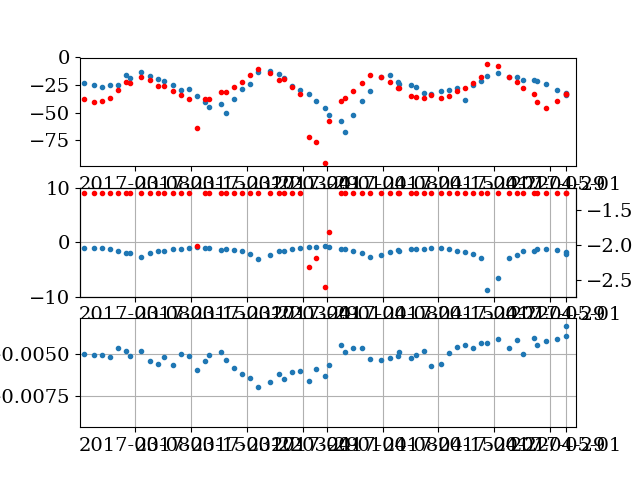

In [68]:
#Amax_guess = compute_Amax(soln['x'], alpha, cn)
#soln['x'] = [2,10.2,0.23]

Amax_guess, my_Amax = compute_Amax_Aobs(soln['x'][0:2], alpha, cn,  L,my_Amax)
Lhat, That, Ahat, a0 = compute_Ahat(soln['x'][0:2], alpha, cn, L)

plt.figure()
ax=plt.subplot(311)
plt.plot(timein, my_Amax,'.')
plt.plot(timein, Amax_guess,'r.')
#plt.plot(timein, a0,'g.')


plt.subplot(312,sharex=ax)
plt.plot(timein[Lhat<0], Lhat[Lhat<0],'.')
plt.plot(timein[Lhat>0], Lhat[Lhat>0],'.')

plt.ylim(-10,10)
plt.grid(b=True)

ax2 = plt.twinx()
ax2.plot(timein, Ahat,'r.')

plt.subplot(313,sharex=ax)
plt.plot(timein,alpha,'.')
plt.grid(b=True)


In [69]:
# Compute the solutions many times
niters = 500
betaa0 = np.zeros((niters,2))
Amax_optimal = np.zeros((niters,nt))
a0_optimal = np.zeros((niters,nt))
for ii in range(niters):
    alpha, cn = extract_alpha_c(ds_S, timein)
    
    # Make sure alpha's sign aligns with the max or else we will never get convergence
    signA = np.sign(Amax_obs)
    signalpha= np.sign(alpha)
    idx = signA != signalpha
    my_Amax = Amax_obs.copy()
    my_Amax[idx] = -1*my_Amax[idx]

    beta0 = [0.,0., ]

    soln = minimize(compute_Amax_error, beta0, args = (L,alpha, cn, my_Amax),
                   bounds=((0,5),(1,25),))
    
    Amax_guess, _ = compute_Amax_Aobs(soln['x'][0:2], alpha, cn, L, my_Amax)
    
    betaa0[ii,:] =soln['x']
    
    _, _, _, a0_optimal[ii,:] = compute_Ahat(soln['x'], alpha, cn, L)
    
    Amax_optimal[ii,:] = Amax_guess
    
    print(ii,soln['x'], soln['fun'])

0 [ 5.         12.98990631] 1.9363031496367036
1 [ 5.         12.36942598] 1.9209611329690242
2 [ 5.        12.5004361] 1.9284634385671875
3 [ 5.         12.21502201] 1.8826835142064315
4 [ 5.         12.50988519] 1.919620436951906
5 [ 5.        11.7880764] 1.9340832095418972
6 [ 5.         12.34795607] 1.9419084917971368
7 [ 5.         11.99594474] 1.930530404036215
8 [ 5.        11.9835939] 1.939648781168168
9 [ 5.         12.04746436] 1.933057632636217
10 [ 5.         12.41550532] 1.89958694933368
11 [ 5.        12.3891368] 1.939500166713737
12 [ 5.         11.87170865] 1.9420350476412047
13 [ 5.         12.43222156] 1.8748394527069276
14 [ 5.         12.51101427] 1.985334256071228
15 [ 5.         12.07753234] 1.9310144711161934
16 [ 5.         12.05808014] 1.9810806266633914
17 [ 5.         11.92999499] 1.946611191712389
18 [ 5.         12.23402769] 1.949829730487844
19 [ 5.         12.27282221] 1.904343358973227
20 [ 5.         11.93961718] 1.9239094485600714
21 [ 5.         12.71

172 [ 5.         12.60384435] 1.8991736668967647
173 [ 5.         12.26700973] 1.9661548615753957
174 [ 5.         12.37485943] 1.9454854252478782
175 [ 5.         12.16733338] 1.8422865957640198
176 [ 5.         12.14303786] 1.9352281151847675
177 [ 5.         12.18966649] 1.9062463955990738
178 [ 5.         12.03071059] 1.8779101367030895
179 [ 5.         12.45695958] 1.853799907899017
180 [ 5.         12.24025524] 1.917014780155802
181 [ 5.         11.99437756] 1.92477845459092
182 [ 5.         12.14925978] 1.9029732925556242
183 [ 5.         12.09833572] 1.8599537782496591
184 [ 5.         12.36381829] 1.8868549629692861
185 [ 5.        12.1606469] 1.9259359632563688
186 [ 5.         12.55404269] 1.8928021493852465
187 [ 5.         12.51022113] 1.8861857100971564
188 [ 5.        11.7266691] 1.942093294133612
189 [ 5.         12.53946236] 1.9683115067212384
190 [ 5.         12.76723189] 1.945514810421691
191 [ 5.         11.97706426] 1.9260017790604542
192 [ 5.         12.81739143] 

341 [ 5.         12.31721888] 1.8952362695314113
342 [ 5.         12.21484427] 1.9168356748191466
343 [ 5.         12.39941688] 1.9215087987960904
344 [ 5.         12.40181808] 1.9275703516224718
345 [ 5.         12.25562612] 1.8318075812039956
346 [ 5.         12.28742948] 1.9019030499603864
347 [ 5.         12.66723306] 1.939598430874431
348 [ 5.         12.44885159] 1.9509917364059486
349 [ 5.         12.26264779] 1.978628236896638
350 [ 5.         11.84540607] 1.9592976779670466
351 [ 5.         12.47811141] 1.9098655972303624
352 [ 5.         12.18776244] 1.9981115998752912
353 [ 5.         12.51651583] 1.931900067350958
354 [ 5.         12.52581086] 1.9678088076698474
355 [ 5.         12.58957386] 1.9367232585279224
356 [ 5.         12.78930234] 1.936106600987563
357 [ 5.         12.17819255] 1.9653001182170817
358 [ 5.         12.11025072] 1.9098948327905143
359 [ 5.         12.48429628] 1.9601437709742209
360 [ 5.        12.3928751] 1.9305541238016102
361 [ 5.         12.951350

<IPython.core.display.Javascript object>


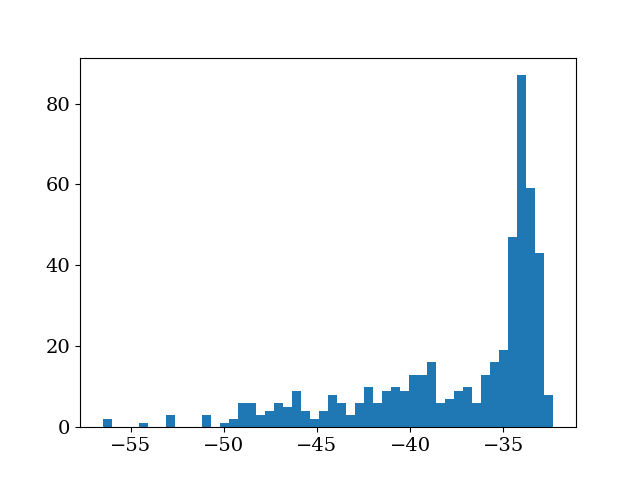

(array([ 2.,  0.,  0.,  0.,  1.,  0.,  0.,  3.,  0.,  0.,  0.,  3.,  0.,
         1.,  2.,  6.,  6.,  3.,  4.,  6.,  5.,  9.,  4.,  2.,  4.,  8.,
         6.,  3.,  6., 10.,  6.,  9., 10.,  9., 13., 13., 16.,  6.,  7.,
         9., 10.,  6., 13., 16., 19., 47., 87., 59., 43.,  8.]),
 array([-56.50343962, -56.01961306, -55.53578649, -55.05195993,
        -54.56813337, -54.0843068 , -53.60048024, -53.11665368,
        -52.63282711, -52.14900055, -51.66517399, -51.18134743,
        -50.69752086, -50.2136943 , -49.72986774, -49.24604117,
        -48.76221461, -48.27838805, -47.79456149, -47.31073492,
        -46.82690836, -46.3430818 , -45.85925523, -45.37542867,
        -44.89160211, -44.40777555, -43.92394898, -43.44012242,
        -42.95629586, -42.47246929, -41.98864273, -41.50481617,
        -41.02098961, -40.53716304, -40.05333648, -39.56950992,
        -39.08568335, -38.60185679, -38.11803023, -37.63420366,
        -37.1503771 , -36.66655054, -36.18272398, -35.69889741,
        -35.

In [70]:
plt.figure()
plt.hist(Amax_optimal[:,285],bins=50)
#plt.plot(alpha)

<IPython.core.display.Javascript object>


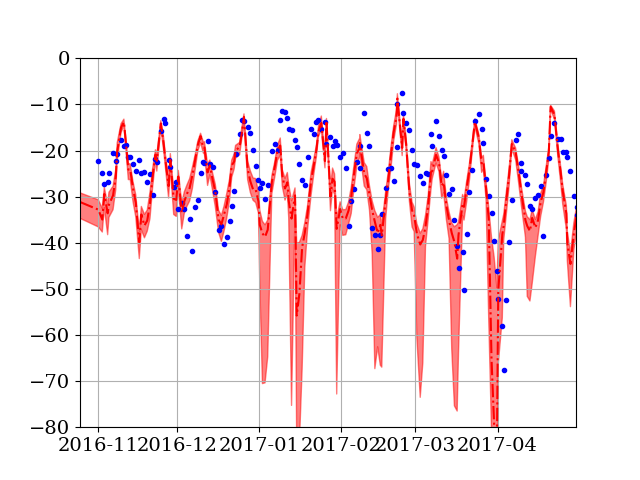

(-80, 80)

In [71]:
plt.figure()
#ax=plt.subplot(211)
plt.plot(timein, my_Amax,'b.')
plt.plot(timein, np.median(Amax_optimal,axis=0),'r-.')
#plt.plot(timein, np.max(Amax_optimal,axis=0),'r+')
#plt.plot(timein, np.min(Amax_optimal,axis=0),'r+')
plt.fill_between(timein, np.min(Amax_optimal,axis=0),
            np.max(Amax_optimal,axis=0) ,color='r' ,alpha=0.5   )
#
#plt.fill_between(timein, np.percentile(Amax_optimal,1,axis=0),
#            np.percentile(Amax_optimal,99,axis=0)     )

plt.grid(b=True)
plt.ylim(-80,80)

<IPython.core.display.Javascript object>


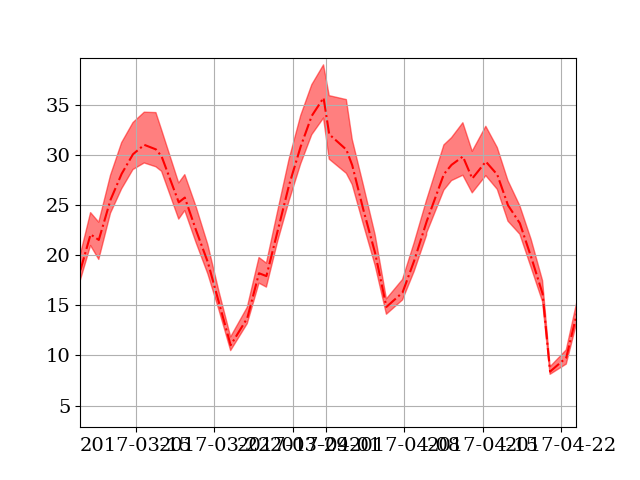

(0, 40)

In [73]:
plt.figure()
#ax=plt.subplot(211)
#plt.plot(timein, my_Amax,'b.')
plt.plot(timein, np.median(a0_optimal,axis=0),'r-.')
#plt.plot(timein, np.max(Amax_optimal,axis=0),'r+')
#plt.plot(timein, np.min(Amax_optimal,axis=0),'r+')
plt.fill_between(timein, np.min(a0_optimal,axis=0),
            np.max(a0_optimal,axis=0) ,color='r' ,alpha=0.5   )
#
#plt.fill_between(timein, np.percentile(Amax_optimal,1,axis=0),
#            np.percentile(Amax_optimal,99,axis=0)     )

#ax2 = plt.twinx()

plt.grid(b=True)
plt.ylim(0,40)

<IPython.core.display.Javascript object>


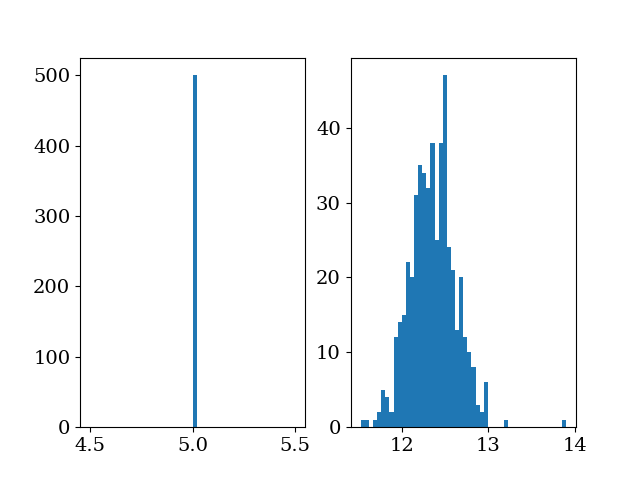

(array([ 1.,  1.,  0.,  1.,  2.,  5.,  4.,  2., 12., 14., 15., 22., 20.,
        31., 35., 34., 32., 38., 25., 38., 47., 24., 21., 13., 20., 12.,
        10.,  8.,  3.,  2.,  6.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.]),
 array([11.5279303 , 11.57524985, 11.6225694 , 11.66988895, 11.71720851,
        11.76452806, 11.81184761, 11.85916716, 11.90648671, 11.95380627,
        12.00112582, 12.04844537, 12.09576492, 12.14308447, 12.19040403,
        12.23772358, 12.28504313, 12.33236268, 12.37968223, 12.42700179,
        12.47432134, 12.52164089, 12.56896044, 12.61628   , 12.66359955,
        12.7109191 , 12.75823865, 12.8055582 , 12.85287776, 12.90019731,
        12.94751686, 12.99483641, 13.04215596, 13.08947552, 13.13679507,
        13.18411462, 13.23143417, 13.27875372, 13.32607328, 13.37339283,
        13.42071238, 13.46803193, 13.51535149, 13.56267104, 13.60999059,
        13.65731014, 13.70462969, 13.75194925, 13.7992688 ,

In [74]:
plt.figure()
plt.subplot(121)
plt.hist(betaa0[:,0], bins=50)

plt.subplot(122)
plt.hist(betaa0[:,1], bins=50)

#plt.subplot(133)
#plt.hist(betaa0[:,2], bins=50)

In [293]:
# Output the beta terms for later prediciton
outputh5 = '../inputs/a0_betas_Crux.h5'
f = h5py.File(outputh5,'w')
g = f.create_group('data')
g.create_dataset('a0-beta',data=betaa0)
f.close()

<IPython.core.display.Javascript object>


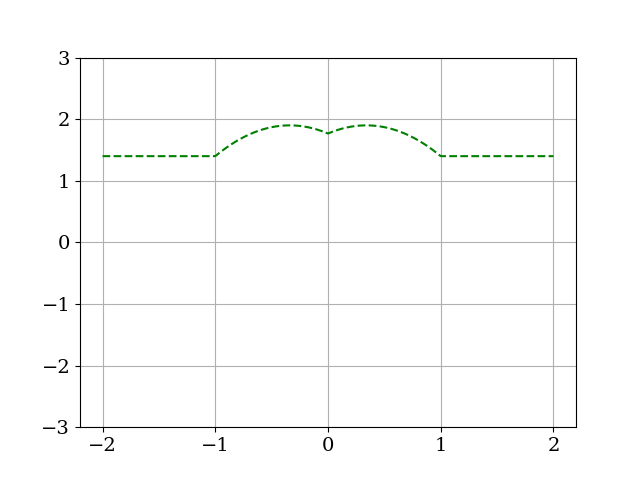

In [239]:
# Test the A_hat function
Lhat = np.linspace(-2,2,500)
def calc_Ahat_That_new(Lhat, coeffs):
    Ah, Al, LA, dLA = coeffs
    idx = Lhat<0
    Ahat = np.zeros_like(Lhat)
    Ahat[idx] = -Ah + 0.5*(Ah-Al) * (1 - np.tanh( (Lhat[idx]+LA)/(0.5*dLA)) ) 
    Ahat[~idx] = -1*(-Ah + 0.5*(Ah-Al) * (1 + np.tanh( (Lhat[~idx]-LA)/(0.5*dLA)) ) )
    return Ahat

def calc_Ahat_quadratic(Lhat, coeffs):
    a0,  x0  = coeffs
    #Ahat= a0+(amax-a0)*np.exp(-((Lhat-x0)/dx)**2.)
    am = (-1-a0)/(-1-x0)**2
    Ahat = am*(Lhat-x0)**2+a0
    Ahat[Lhat<-1] = -1
    
    idx = Lhat > 0
    Ahat[idx] = -am*(Lhat[idx]+x0)**2-a0
    Ahat[Lhat>1] = 1


    return Ahat

def calc_That_quadratic(Lhat, coeffs):
    a0, a1,  x0  = coeffs
    #Ahat= a0+(amax-a0)*np.exp(-((Lhat-x0)/dx)**2.)
    am = (-a1+a0)/(-1-x0)**2
    Ahat = -am*(Lhat-x0)**2+a0
    Ahat[Lhat<-1] = a1
    
    idx = Lhat > 0
    Ahat[idx] = -am*(Lhat[idx]+x0)**2+a0
    Ahat[Lhat>1] = a1


    return Ahat


#Ahat = calc_Ahat_That_new(Lhat, Ahat_args)
#Ahat_g = calc_Ahat_quadratic(Lhat,(-2.68,-0.54))
Ahat_g = calc_That_quadratic(Lhat,(1.9,1.4,-0.34))


plt.figure()
#plt.plot(Lhat,Ahat,'r--')
                                 
plt.plot(Lhat,Ahat_g,'g--')
plt.ylim(-3,3)
plt.grid(b=True)